Optimisation de l'entrainement pour `focus` 
This is the same function as used in `10_Transfer_learning_what_networks.ipynb`
> ... TODO ... # TODO test without circular padding, with Adam, with no warmstart 

    model = torchvision.models.resnet18(weights=None)

# optimize meta-parameters

In [1]:
import dataclasses

In [2]:
%ls -ltr cached_data/34*

-rw-r--r--  1 laurent  staff  122880 28 nov.  12:03 cached_data/34_optuna_resnet.sqlite3
-rw-r--r--  1 laurent  staff  204800 30 nov.  07:51 cached_data/34_optuna_bis.sqlite3
-rw-r--r--  1 laurent  staff  163840  1 déc.  10:52 cached_data/34_optuna_convnext.sqlite3
-rw-r--r--  1 laurent  staff  143360  3 déc.  22:32 cached_data/34_optuna.sqlite3


In [3]:
# print_gpu_memory()

# print(path_save)
# %ls -l {path}*

# %rm "cached_data/34_optuna.sqlite3"  # FORCING RECOMPUTE

In [4]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [5]:
# import retinoto_py as fovea
# batch_size = 64
# args = fovea.Params()
# opts_dict = dict(do_fovea=True, num_epochs=1, verbose=False)
# args = dataclasses.replace(args, **opts_dict)
# args

In [ ]:
import retinoto_py as fovea
batch_size = 256
args = fovea.Params(do_fovea=True, num_epochs=1, subset_factor=25, verbose=False)
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-03_21-36-24	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.


Params(image_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-5.0, padding_mode='zeros', seed=2018, batch_size=256, num_workers=0, in_memory=True, model_name='convnext_base', do_scratch=False, num_epochs=1, n_train_stop=65536, n_val_stop=256, lr=3e-06, delta1=0.05, delta2=0.01, weight_decay=0.02, label_smoothing=0.03, shuffle=True, verbose=False)

In [7]:
%ls -ltr cached_data/32*

-rw-r--r--  1 laurent  staff  178843891 27 nov.  09:12 cached_data/32_fovea_model_name=resnet101_dataset=bbox_retrained_bkp.pth
-rw-r--r--  1 laurent  staff       2132 27 nov.  09:47 cached_data/32_fovea_model_name=resnet101_dataset=bbox_retrained_bkp.json
-rw-r--r--  1 laurent  staff       2140 27 nov.  18:05 cached_data/32_fovea_model_name=resnet101_dataset=full.json
-rw-r--r--  1 laurent  staff          0 27 nov.  19:37 cached_data/32_fovea_model_name=resnet101_dataset=full.lock
-rw-r--r--  1 laurent  staff  178837571 27 nov.  20:42 cached_data/32_fovea_model_name=resnet101_dataset=full.pth
-rw-r--r--  1 laurent  staff          0 27 nov.  23:43 cached_data/32_fovea_model_name=resnet101_dataset=bbox.lock
-rw-r--r--  1 laurent  staff  178837571 28 nov.  09:05 cached_data/32_fovea_model_name=resnet101_dataset=bbox.pth
-rw-r--r--  1 laurent  staff       1955 28 nov.  09:05 cached_data/32_fovea_model_name=resnet101_dataset=bbox.json


In [ ]:
%ls -ltr cached_data/33*

-rw-r--r--  1 laurent  staff  178843891 27 nov.  09:12 cached_data/32_fovea_model_name=resnet101_dataset=bbox_retrained_bkp.pth
-rw-r--r--  1 laurent  staff       2132 27 nov.  09:47 cached_data/32_fovea_model_name=resnet101_dataset=bbox_retrained_bkp.json
-rw-r--r--  1 laurent  staff       2140 27 nov.  18:05 cached_data/32_fovea_model_name=resnet101_dataset=full.json
-rw-r--r--  1 laurent  staff          0 27 nov.  19:37 cached_data/32_fovea_model_name=resnet101_dataset=full.lock
-rw-r--r--  1 laurent  staff  178837571 27 nov.  20:42 cached_data/32_fovea_model_name=resnet101_dataset=full.pth
-rw-r--r--  1 laurent  staff          0 27 nov.  23:43 cached_data/32_fovea_model_name=resnet101_dataset=bbox.lock
-rw-r--r--  1 laurent  staff  178837571 28 nov.  09:05 cached_data/32_fovea_model_name=resnet101_dataset=bbox.pth
-rw-r--r--  1 laurent  staff       1955 28 nov.  09:05 cached_data/32_fovea_model_name=resnet101_dataset=bbox.json


In [ ]:
dataset = 'bbox'
TRAIN_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'train'
train_dataset = fovea.get_dataset(args, TRAIN_DATA_DIR)
train_loader = fovea.get_loader(args, train_dataset)
VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR)
val_loader = fovea.get_loader(args, val_dataset)

Putting images in memory:   0%|          | 0/65536 [00:00<?, ?it/s]

Putting images in memory:   0%|          | 0/256 [00:00<?, ?it/s]

In [10]:
# model_filename = None # do not use resumed net
# model_filename = args.data_cache / f'32_fovea_model_name={args.model_name}_dataset={dataset}_retrained_bkp.pth'
# model_filename = args.data_cache / f'32_fovea_model_name={args.model_name}_dataset={dataset}.pth'
model_filename = args.data_cache / f'33_fovea_model_name={args.model_name}_dataset={dataset}.pth'
model = fovea.load_model(args, model_filename=model_filename)
model_filename

PosixPath('cached_data/33_fovea_model_name=convnext_base_dataset=bbox.pth')

In [11]:
accuracy = fovea.get_validation_accuracy(args, model, val_loader, f"Evaluating {args.model_name} on dataset: {dataset}")


Evaluating convnext_base on dataset: bbox:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
accuracy

0.78515625

In [13]:
def objective(trial):
    args = fovea.Params(do_fovea=True, num_epochs=1, verbose=False)
    model = fovea.load_model(args, model_filename=model_filename)

    args.batch_size = trial.suggest_int('batch_size', 16, 512, log=True, step=1)
    args.rs_min = trial.suggest_float( 'rs_min', -1, -1)
    args.rs_max = trial.suggest_float( 'rs_max', -8, -4)
    
    scale = 10
    if args.delta2>0: args.delta2 = trial.suggest_float('delta2', args.delta2 / scale, min((args.delta2 * scale, 1)), log=True)
    args.lr = trial.suggest_float('lr', args.lr / scale, args.lr * scale, log=True)

    args.delta1 = trial.suggest_float('delta1', args.delta1 / scale, min((args.delta1 * scale, 1)), log=True)
    if args.weight_decay>0: args.weight_decay = trial.suggest_float('weight_decay', args.weight_decay / scale, args.weight_decay * scale, log=True)
    if args.label_smoothing>0: args.label_smoothing = trial.suggest_float('label_smoothing', args.label_smoothing / scale, args.label_smoothing * scale, log=True)

    scale = 100 

    # args.im_mean = trial.suggest_float('im_mean', opt.im_mean / scale, opt.im_mean * scale, log=True)
    # args.im_std = trial.suggest_float('im_std', opt.im_std / scale, opt.im_std * scale, log=True)

    # get the architecture of the network, train and get accuracy on the validation set
    train_dataset.transform = train_dataset.transform = fovea.get_preprocess(args) 
    train_loader = fovea.get_loader(args, train_dataset)
    val_loader = fovea.get_loader(args, val_dataset)
    _, df_train = fovea.train_model(args, model=model, train_loader=train_loader, val_loader=val_loader)
    accuracy = df_train['acc_val'].mean()
    
    return accuracy
    
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(storage=f"sqlite:///cached_data/34_optuna.sqlite3", 
                            sampler=optuna.samplers.TPESampler(multivariate=False, warn_independent_sampling=False),
                            direction='maximize', load_if_exists=True, study_name=f"34_optuna")
print(f'Starting optimization with params: {args} on {max(150-len(study.trials), 0)} trials - {len(study.trials)} ')
study.optimize(objective, n_trials=max((150-len(study.trials), 0)), n_jobs=1, show_progress_bar=True)

print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
# print("Trials: ", study.trials)

Starting optimization with params: Params(image_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-5.0, padding_mode='zeros', seed=2018, batch_size=256, num_workers=0, in_memory=True, model_name='convnext_base', do_scratch=False, num_epochs=1, n_train_stop=65536, n_val_stop=256, lr=3e-06, delta1=0.05, delta2=0.01, weight_decay=0.02, label_smoothing=0.03, shuffle=True, verbose=False) on 120 trials - 30 


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/3855 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/963 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/606 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/590 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/809 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/202 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/771 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1110 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/277 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/2259 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/829 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1170 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/292 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1927 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/2048 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/512 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1724 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/431 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/3120 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/780 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/3855 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/963 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/3120 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/780 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/2621 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/655 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/963 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/697 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/648 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1524 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1524 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/381 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1310 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/3120 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/780 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1985 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1820 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1008 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1008 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1057 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1310 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/689 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1008 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/579 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/978 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/244 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1489 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1170 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/292 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/524 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/528 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/923 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/753 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch=1/1:   0%|          | 0/1236 [00:00<?, ?it/s]

[W 2025-12-04 08:08:17,206] Trial 69 failed with parameters: {'batch_size': 53, 'rs_max': -5.036142050017083, 'delta2': 0.002755656618204581, 'lr': 1.2420616321804988e-06, 'delta1': 0.16494941102549504, 'weight_decay': 0.04885869686263591, 'label_smoothing': 0.17871162235962118} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/laurent/app54_nextcloud/science/retinoto_py/.venv/lib/python3.14/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/qt/n82pbkv93fjb7bpt0pj1992w0000gn/T/ipykernel_72534/3505252946.py", line 25, in objective
    _, df_train = fovea.train_model(args, model=model, train_loader=train_loader, val_loader=val_loader)
                  ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurent/app54_nextcloud/science/retinoto_py/src/retinoto_py/retinoto_py.py", line 143, in train_model
    loss.backw

KeyboardInterrupt: 

In [14]:
import optuna.visualization.matplotlib as vis

/var/folders/qt/n82pbkv93fjb7bpt0pj1992w0000gn/T/ipykernel_72534/173483681.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  vis.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

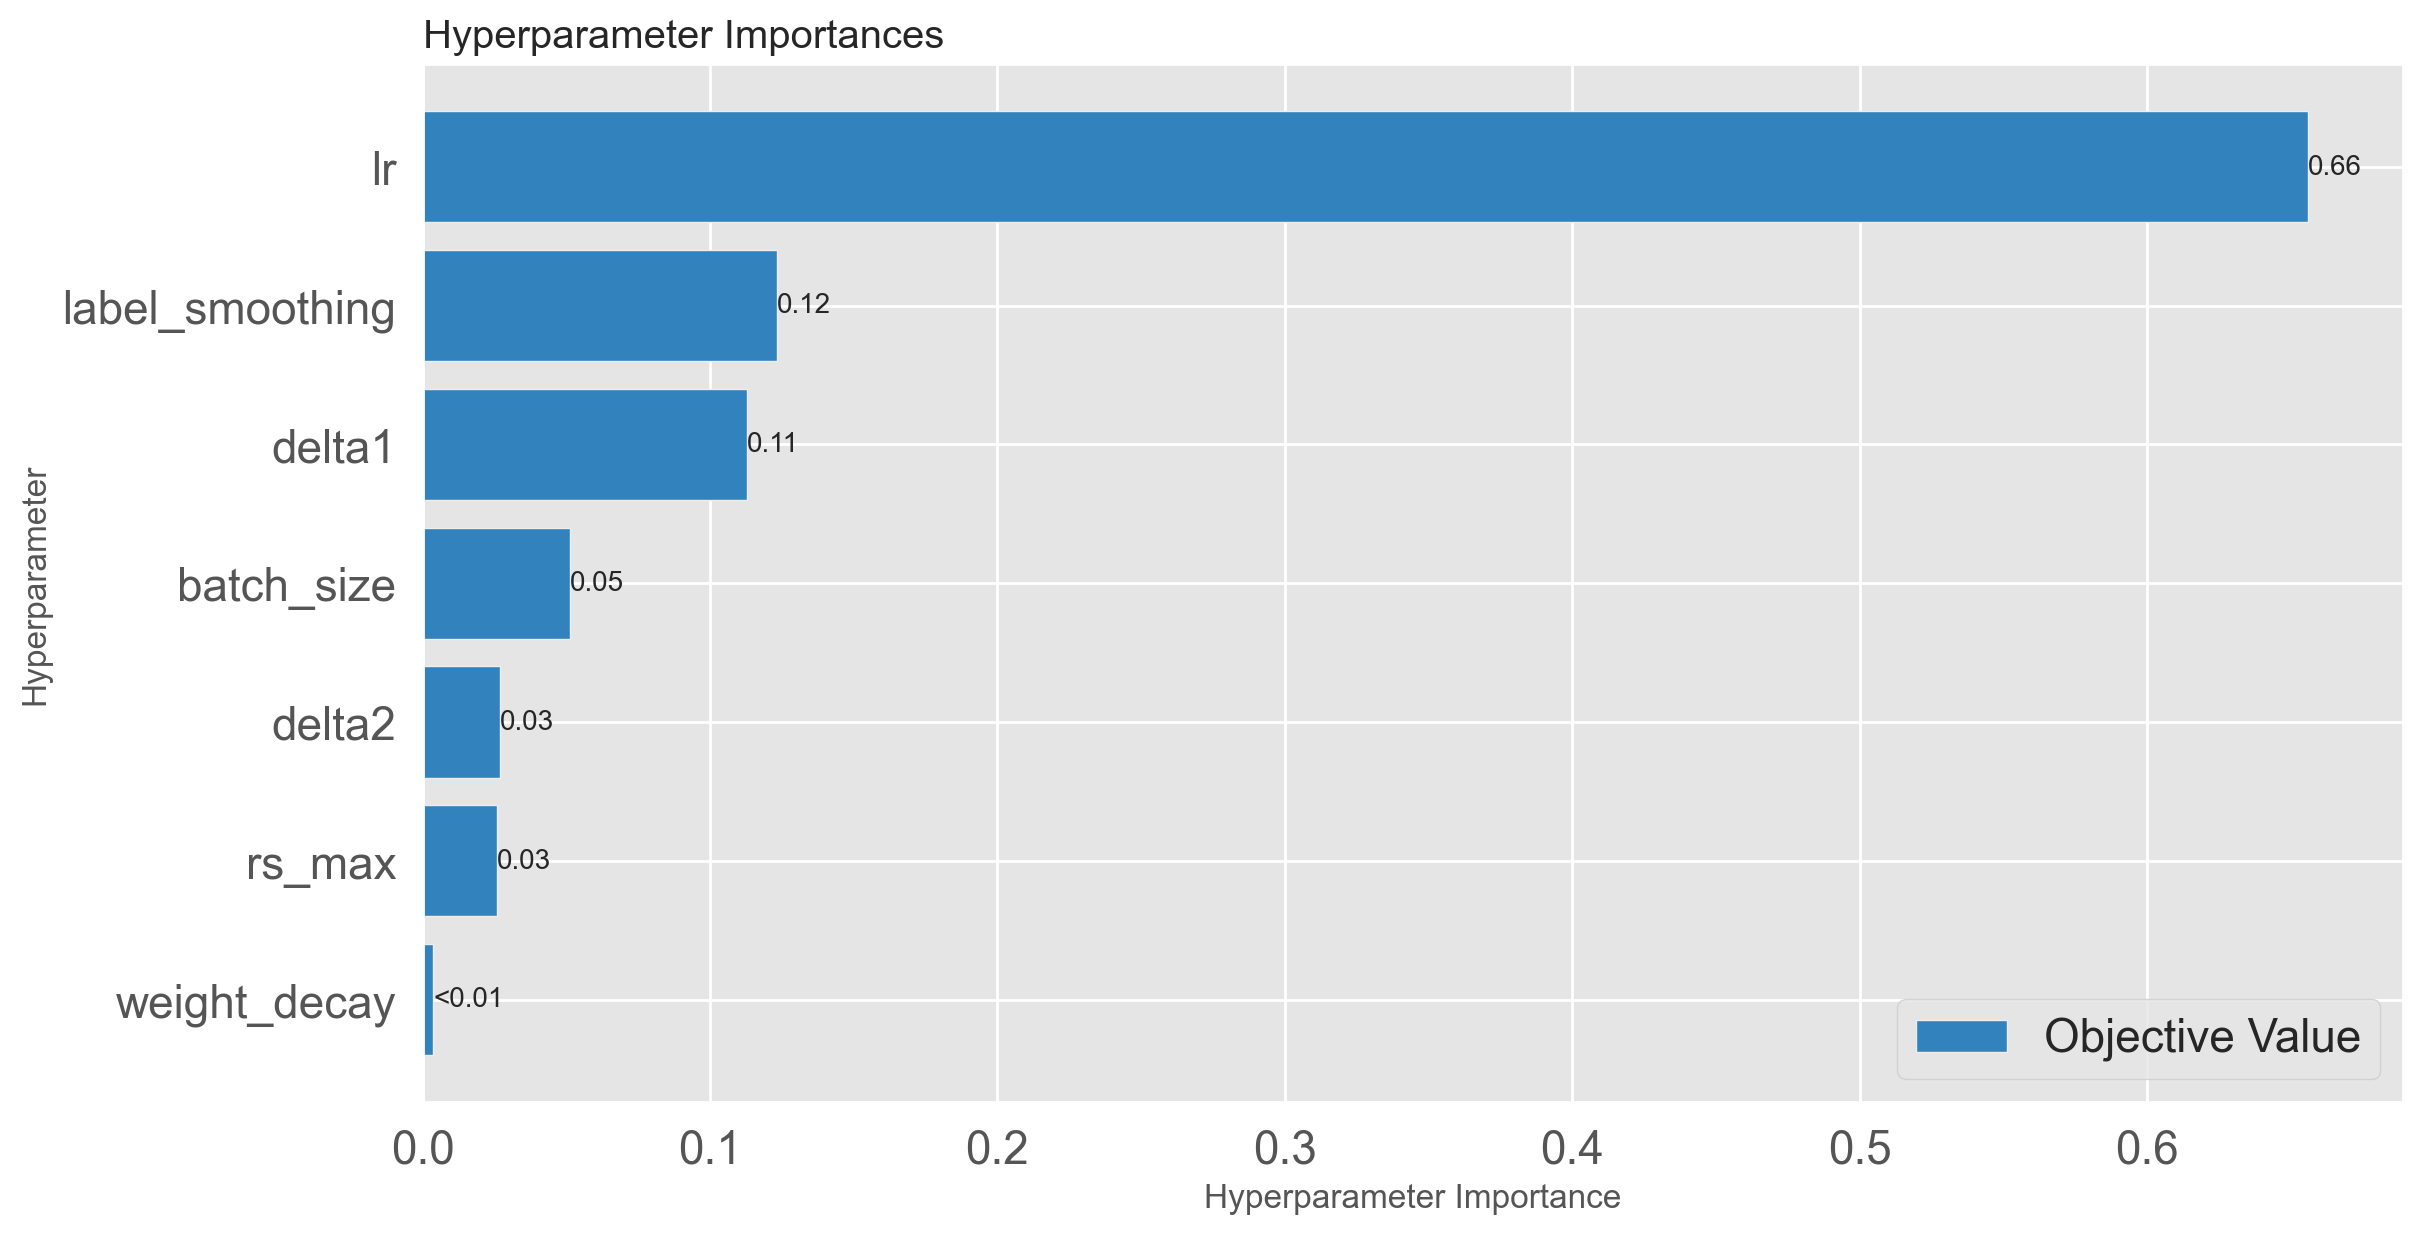

In [15]:
vis.plot_param_importances(study)

In [16]:
# df = study.trials_dataframe()   
params = sorted({k for t in study.trials for k in t.params})
params

['batch_size',
 'delta1',
 'delta2',
 'label_smoothing',
 'lr',
 'rs_max',
 'weight_decay']

/Users/laurent/app54_nextcloud/science/retinoto_py/.venv/lib/python3.14/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'log_transform'
  cset = contour_func(
/Users/laurent/app54_nextcloud/science/retinoto_py/.venv/lib/python3.14/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'log_transform'
  cset = contour_func(
/Users/laurent/app54_nextcloud/science/retinoto_py/.venv/lib/python3.14/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'log_transform'
  cset = contour_func(
/Users/laurent/app54_nextcloud/science/retinoto_py/.venv/lib/python3.14/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'log_transform'
  cset = contour_func(
/Users/laurent/app54_nextcloud/science/retinoto_py/.venv/lib/python3.14/site-packages/seaborn/distributions.py:1176: UserWarning: The fo

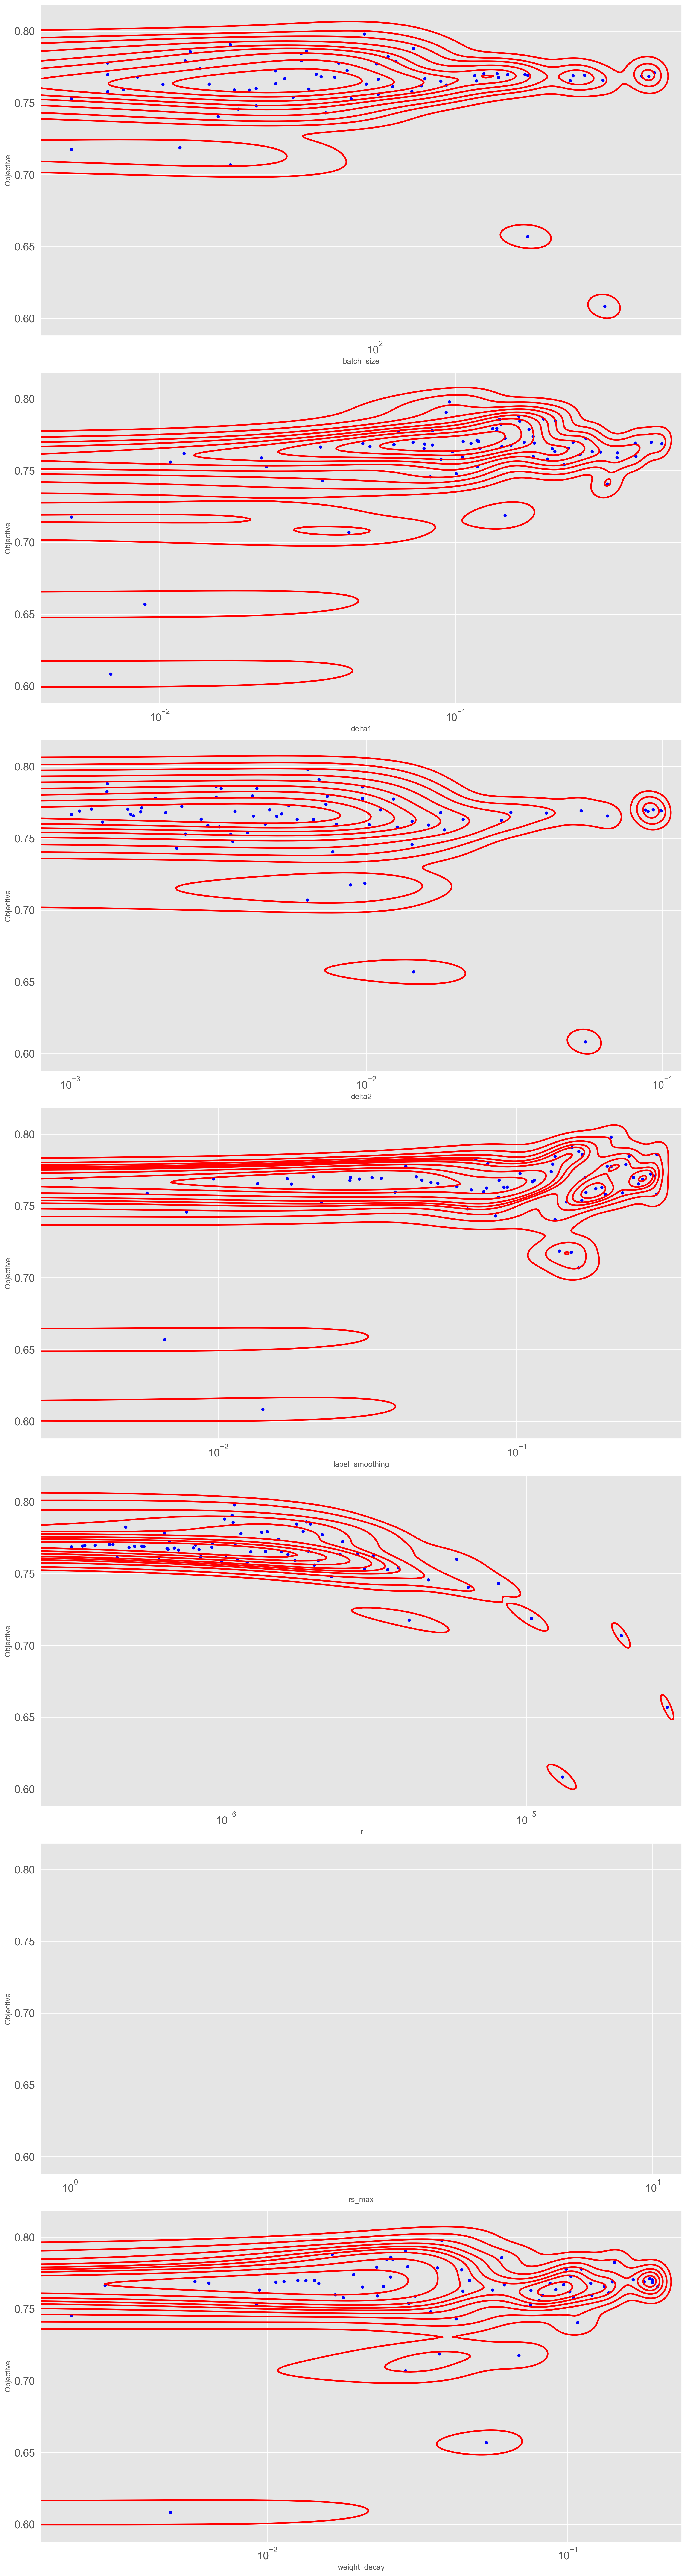

In [23]:
import seaborn as sns
fig, axes = fovea.plt.subplots(len(params), 1, figsize=(15, 8*len(params)), sharey=True)

for ax, pname in zip(axes, params):
    xs = [t.params[pname] for t in study.trials if pname in t.params]
    ys = [t.value for t in study.trials if pname in t.params]

    sns.kdeplot(
        x=xs,
        y=ys,
        ax=ax,
        color="red",
        bw_adjust=0.5,  # Bandwidth adjustment (smoothing level)
        log_transform=(True, False),  # Log transform only the x-axis
    )

    ax.scatter(xs, ys, s=20, alpha=1., color='blue')

    ax.set_xlabel(pname)
    ax.set_xscale('log')
    ax.set_ylabel("Objective")

fovea.plt.tight_layout()

In [18]:
# vis.plot_contour(study, params=["weight_quanta", "resample_rate"])
# vis.plot_contour(study, params=["num_particles", "chunk_size"])